In [1]:
# --- 1.0 Import Libraries ---

import warnings
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.saving import register_keras_serializable

# Enabling mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Filter warnings and set up plots
warnings.filterwarnings(action="ignore")
%matplotlib inline

In [2]:
# --- 1.1 Load Filepaths and Labels (FIXED) ---

def create_df_from_dirs(base_path, split_name):
    """Creates a DataFrame from 'normal' and 'opacity' subdirs for a given split."""
    filepaths = []
    labels = []
    
    dir_types = [
        (os.path.join(base_path, split_name, "normal"), "Normal"),
        (os.path.join(base_path, split_name, "opacity"), "Pneumonia")
    ]
    
    for dir_path, label in dir_types:
        if os.path.isdir(dir_path):
            flist = os.listdir(dir_path)
            for f in flist:
                if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                    filepaths.append(os.path.join(dir_path, f))
                    labels.append(label)
        else:
            print(f"Warning: Directory not found {dir_path}")
            
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Define the base path to your dataset
base_dataset_path = r"/Users/sairamsp/VIT Chennai/Second Year/Dissertation 2/AttentiveLightNet/data"

# Create the 3 separate, non-overlapping DataFrames
train_df = create_df_from_dirs(base_dataset_path, "train")
val_df = create_df_from_dirs(base_dataset_path, "val")
test_df = create_df_from_dirs(base_dataset_path, "test")

# Create a combined DataFrame for EDA plotting *only*
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Shuffle the training dataframe (good practice for training)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("--- DataFrames Created ---")
print(f"Training set shape:   {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape:       {test_df.shape}")

print("\n--- Total Class Counts (for EDA) ---")
print(all_df['labels'].value_counts())

--- DataFrames Created ---
Training set shape:   (4192, 2)
Validation set shape: (1040, 2)
Test set shape:       (624, 2)

--- Total Class Counts (for EDA) ---
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


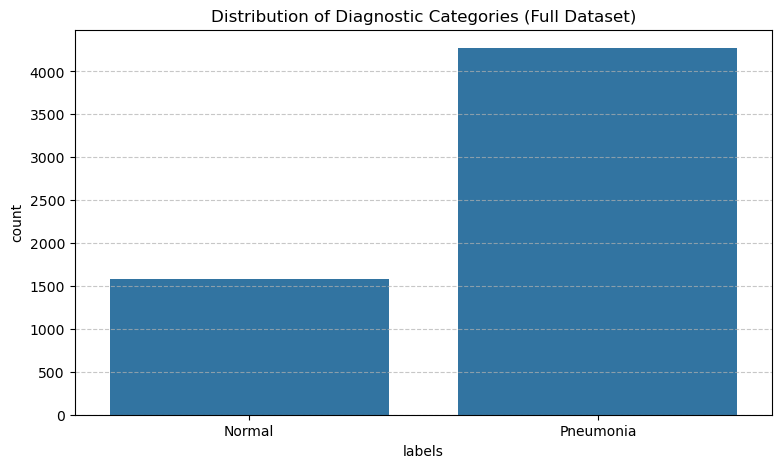

In [67]:
# --- 1.2 Plot Class Distribution ---
plt.figure(figsize=(9, 5))
sns.countplot(x='labels', data=all_df) # Plotting distribution from all data
plt.title('Distribution of Diagnostic Categories (Full Dataset)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [68]:
# --- 1.3 Analyze Image Dimensions ---
sample_count = min(350, len(all_df))
selected_images_paths = all_df['filepaths'].sample(sample_count, random_state=42).tolist()
dimension_records = []

for path in selected_images_paths:
    try:
        with Image.open(path) as img:
            dimension_records.append(img.size)
    except Exception:
        continue

dimension_df = pd.DataFrame(dimension_records, columns=["width", "height"])
print(dimension_df.describe())

             width       height
count   350.000000   350.000000
mean   1336.760000   975.960000
std     378.451671   403.653499
min     460.000000   157.000000
25%    1058.000000   672.000000
50%    1260.000000   856.000000
75%    1573.000000  1171.000000
max    2572.000000  2519.000000


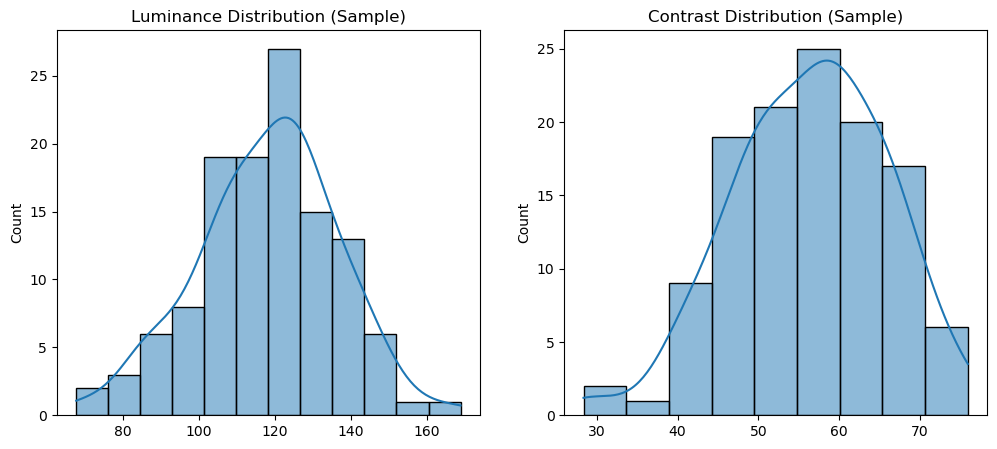

In [69]:
# --- 1.4 Analyze Brightness and Contrast ---
brightness_metrics = []
contrast_metrics = []

for path in selected_images_paths[:120]: # Sample 120 images for this demo
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        brightness_metrics.append(np.mean(img))
        contrast_metrics.append(np.std(img))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(brightness_metrics, kde=True, ax=ax[0]).set_title("Luminance Distribution (Sample)")
sns.histplot(contrast_metrics, kde=True, ax=ax[1]).set_title("Contrast Distribution (Sample)")
plt.show()

In [70]:
# --- 2.1 Define Preprocessing Function for Generator ---

def enhance_and_prepare(image):
    """
    Applies CLAHE enhancement and scales image to [0, 1].
    Assumes input is a (224, 224, 1) NumPy array from the generator, 
    with values in the [0, 255] range.
    """
    # Squeeze to (224, 224) for cv2 compatibility
    image_squeezed = image.squeeze()
    
    # Cast to 8-bit unsigned int (CLAHE requires uint8)
    image_uint8 = image_squeezed.astype('uint8')
        
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image_uint8)
    
    # Scale back to [0, 1] float32 for the network
    image_float32 = enhanced_image.astype("float32") / 255.0
    
    # Expand dims back to (224, 224, 1)
    return np.expand_dims(image_float32, axis=-1)

In [71]:
# --- 2.2 Check Split Shapes ---
# (This was cell 16 in the original notebook)
print(f"Training set shape:   {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape:       {test_df.shape}")

Training set shape:   (4192, 2)
Validation set shape: (1040, 2)
Test set shape:       (624, 2)


In [72]:
# --- 2.3 Create Data Generators ---


train_image_gen = ImageDataGenerator(
    preprocessing_function=enhance_and_prepare,  # <-- Using CLAHE
    rotation_range=15,       # Increased from 10
    width_shift_range=0.15,  # Increased from 0.1
    height_shift_range=0.15, # Increased from 0.1
    zoom_range=0.15,         # Increased from 0.1
    shear_range=0.1,         # <-- Added shear
    horizontal_flip=True
)

# Validation and test generators only apply the preprocessing
val_test_image_gen = ImageDataGenerator(
    preprocessing_function=enhance_and_prepare  # <-- Using CLAHE
)

train_generator = train_image_gen.flow_from_dataframe(
    dataframe=train_df,  # Using clean train_df
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=32,
    shuffle=True  # Shuffle the training data
)

val_generator = val_test_image_gen.flow_from_dataframe(
    dataframe=val_df,  # Using clean val_df
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

test_generator = val_test_image_gen.flow_from_dataframe(
    dataframe=test_df,  # Using clean test_df
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 4192 validated image filenames belonging to 2 classes.
Found 1040 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [73]:
# --- 2.4 Get Class Labels ---
classes = list(train_generator.class_indices.keys())
print(f"Class indices: {train_generator.class_indices}")

Class indices: {'Normal': 0, 'Pneumonia': 1}


In [74]:
# --- 3.1 Custom Activation & Model Components ---

@register_keras_serializable(package="Custom")
def swish_plus(x):
    """Custom activation function."""
    return x * tf.nn.sigmoid(1.5 * x)

# --- 3.2 Squeeze-and-Excitation (SE) Block ---
def se_block(input_tensor, ratio=8):
    """Squeeze-and-Excitation attention block."""
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

# --- 3.3 Dynamic Dropout Layer ---
@register_keras_serializable(package="Custom")
class DynamicDropout(layers.Layer):
    """Custom dropout layer with a rate that updates each epoch."""
    def __init__(self, initial_rate=0.1, final_rate=0.5, total_epochs=30, **kwargs):
        super(DynamicDropout, self).__init__(**kwargs)
        self.initial_rate = initial_rate
        self.final_rate = final_rate
        self.total_epochs = total_epochs
        self.current_rate = tf.Variable(initial_value=initial_rate, trainable=False, dtype=tf.float32)

    def update_rate(self, epoch):
        """Callback function will call this to update the rate."""
        rate = self.initial_rate + (self.final_rate - self.initial_rate) * (epoch / self.total_epochs)
        rate = tf.cast(tf.clip_by_value(rate, self.initial_rate, self.final_rate), tf.float32)
        self.current_rate.assign(rate)

    def call(self, inputs, training=False):
        """Apply dropout only during training."""
        if training:
            rate_cast = tf.cast(self.current_rate, inputs.dtype)
            return tf.nn.dropout(inputs, rate=rate_cast)
        return inputs

    def get_config(self):
        """Allows model saving."""
        config = super(DynamicDropout, self).get_config()
        config.update({
            "initial_rate": self.initial_rate,
            "final_rate": self.final_rate,
            "total_epochs": self.total_epochs,
        })
        return config

# --- 3.4 Multi-branch Convolution (Inception) Module ---
def inception_module(x, filters):
    """Inception-style module with SE block."""
    branch1 = layers.Conv2D(filters, (1, 1), padding='same', activation=swish_plus)(x)
    branch2 = layers.SeparableConv2D(filters, (3, 3), padding='same', activation=swish_plus)(x)
    branch3 = layers.SeparableConv2D(filters, (5, 5), padding='same', activation=swish_plus)(x)
    branch4 = layers.MaxPooling2D((3, 3), strides=1, padding='same')(x)
    branch4 = layers.Conv2D(filters, (1, 1), padding='same', activation=swish_plus)(branch4)

    x = layers.Concatenate()([branch1, branch2, branch3, branch4])
    x = layers.BatchNormalization()(x)
    x = se_block(x)  # Apply SE attention
    return x

In [76]:
# --- 3.5 Custom Focal Loss Function ---

@register_keras_serializable(package="Custom")  # <-- Register the CLASS
class CustomFocalLoss(keras.losses.Loss):
    """
    Keras-native Focal Loss class.
    'gamma' focuses the model on hard-to-classify examples.
    """
    def __init__(self, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Your original focal_loss logic goes here
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross-entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Get the probability of the true class
        pt = K.sum(y_true * y_pred, axis=-1)
        
        # Calculate focal component
        focal_component = K.pow(1 - pt, self.gamma)
        
        # Sum loss over classes, then average over batch
        loss = focal_component * K.sum(cross_entropy, axis=-1)
        return K.mean(loss)

    def get_config(self):
        # This allows Keras to save and load the 'gamma' parameter
        config = super().get_config()
        config.update({"gamma": self.gamma})
        return config

In [77]:
# --- 3.6 Model Architecture Function: AttentiveLightNet ---

def build_attentive_lightnet(input_shape=(224, 224, 1), num_classes=2, total_epochs=30):
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same',
                      activation=swish_plus,
                      kernel_regularizer=regularizers.l2(0.0001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Block 1: Inception + SE
    x = inception_module(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.1)(x)

    # Block 2: Inception + SE
    x = inception_module(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # Block 3: Inception + SE
    x = inception_module(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.SpatialDropout2D(0.3)(x)

    # Global Pooling and Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=swish_plus, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = DynamicDropout(initial_rate=0.1, final_rate=0.5, total_epochs=total_epochs, name='dynamic_dropout_1')(x)

    x = layers.Dense(64, activation=swish_plus, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = DynamicDropout(initial_rate=0.1, final_rate=0.5, total_epochs=total_epochs, name='dynamic_dropout_2')(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="AttentiveLightNet")
    return model

In [78]:
# --- 4.1 Build and Compile Model ---

TOTAL_EPOCHS = 30
model = build_attentive_lightnet(input_shape=(224, 224, 1), num_classes=2, total_epochs=TOTAL_EPOCHS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=CustomFocalLoss(gamma=2.0),
              metrics=['accuracy'])

In [79]:
# --- 4.2 Model Summary ---

model.summary()

Model: "AttentiveLightNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 56, 56,    │          0 │ max_pooling2d_21… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 56, 56,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │        544 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_18 │ (None, 56, 56,    │        688 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_19 │ (None, 56, 56,    │        944 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │        544 │ max_pooling2d_22… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 56, 56,    │          0 │ conv2d_22[0][0],  │
│ (Concatenate)       │ 128)              │            │ separable_conv2d… │
│                     │                   │            │ separable_conv2d… │
│                     │                   │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_9[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 16)        │      2,064 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │      2,176 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 128)              │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 28, 28,    │          0 │ multiply_9[0][0]

 Total params: 345,266 (1.32 MB)

 Trainable params: 343,442 (1.31 MB)

 Non-trainable params: 1,824 (7.12 KB)

In [80]:
# --- 4.3 Calculate Class Weights ---
class_to_index = train_generator.class_indices

# Use the 'train_df' DataFrame created in cell 2
y_train_int = train_df['labels'].apply(lambda x: class_to_index[x]) 

class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

class_weights_dict = dict(enumerate(class_weights_list))
print(f"Calculated Class Weights: {class_weights_dict}")

Calculated Class Weights: {0: np.float64(1.9371534195933457), 1: np.float64(0.6739549839228296)}


In [81]:
# --- 4.4 Define Callbacks ---

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=3, min_lr=1e-6, verbose=1)

# Custom Callback to Update Dropout Rate
class DynamicDropoutCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if isinstance(layer, DynamicDropout):
                layer.update_rate(epoch)

dynamic_dropout_callback = DynamicDropoutCallback()

# Combine all callbacks
callbacks_list = [early_stopping, reduce_lr, dynamic_dropout_callback]

In [82]:
# --- 4.5 Train the Model (FIXED) ---

history = model.fit(
    train_generator, 
    epochs=TOTAL_EPOCHS, 
    validation_data=val_generator, 
    verbose=1, 
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 518ms/step - accuracy: 0.7359 - loss: 0.1648 - val_accuracy: 0.7433 - val_loss: 0.1775 - learning_rate: 1.0000e-04
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 576ms/step - accuracy: 0.7975 - loss: 0.1373 - val_accuracy: 0.7433 - val_loss: 0.1841 - learning_rate: 1.0000e-04
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 675ms/step - accuracy: 0.8094 - loss: 0.1287 - val_accuracy: 0.7433 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8367 - loss: 0.1191
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 911ms/step - accuracy: 0.8342 - loss: 0.1206 - val_accuracy: 0.7433 - val_loss: 0.4026 - learning_rate: 1.0000e-04
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 806ms/step - accuracy: 0.8266 - loss: 0.1189 - val_accuracy: 0.7442 - val_loss: 0.2127 - learning_rate: 5.0000e-05
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 671ms/

In [83]:
# --- 5.1 Evaluate on Test Set ---

print("\n--- Test Set Evaluation ---")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


--- Test Set Evaluation ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8269 - loss: 0.1369
Test Loss: 0.1369
Test Accuracy: 82.69%


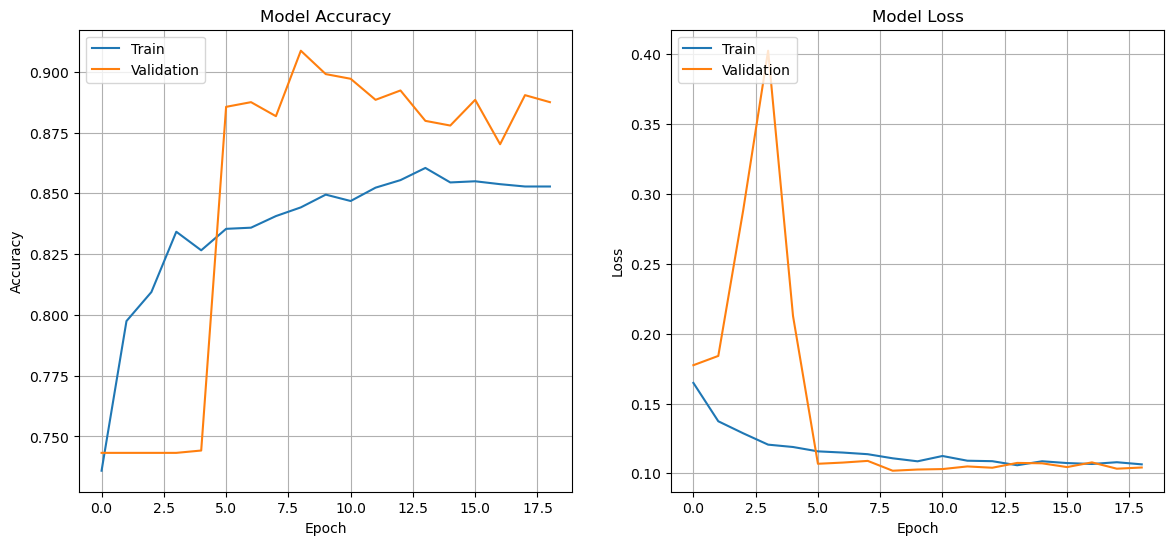

In [84]:
# --- 5.2 Plot Accuracy and Loss Curves ---

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.show()

In [85]:
# --- 5.3 Generate Predictions and Classification Report ---

# Get predictions
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1) # Pick class with highest probability

# Get true labels
y_true = test_generator.classes

# Map integer predictions back to string labels
labels_map = {v: k for k, v in train_generator.class_indices.items()}
pred_labels_str = [labels_map[k] for k in pred_classes]
y_true_labels_str = [labels_map[k] for k in y_true]

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true_labels_str, pred_labels_str))
print("Accuracy of the Model: {:.1f}%".format(accuracy_score(y_true_labels_str, pred_labels_str) * 100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.86      0.65      0.74       234
   Pneumonia       0.81      0.94      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624

Accuracy of the Model: 82.7%


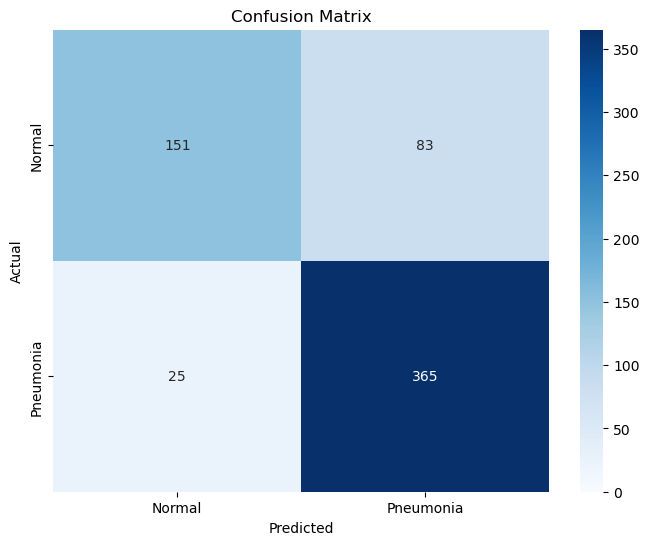

In [86]:
# --- 5.4 Plot Confusion Matrix ---

class_labels_list = list(train_generator.class_indices.keys())

cm = confusion_matrix(y_true_labels_str, pred_labels_str, labels=class_labels_list)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues',
            xticklabels=class_labels_list, yticklabels=class_labels_list)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


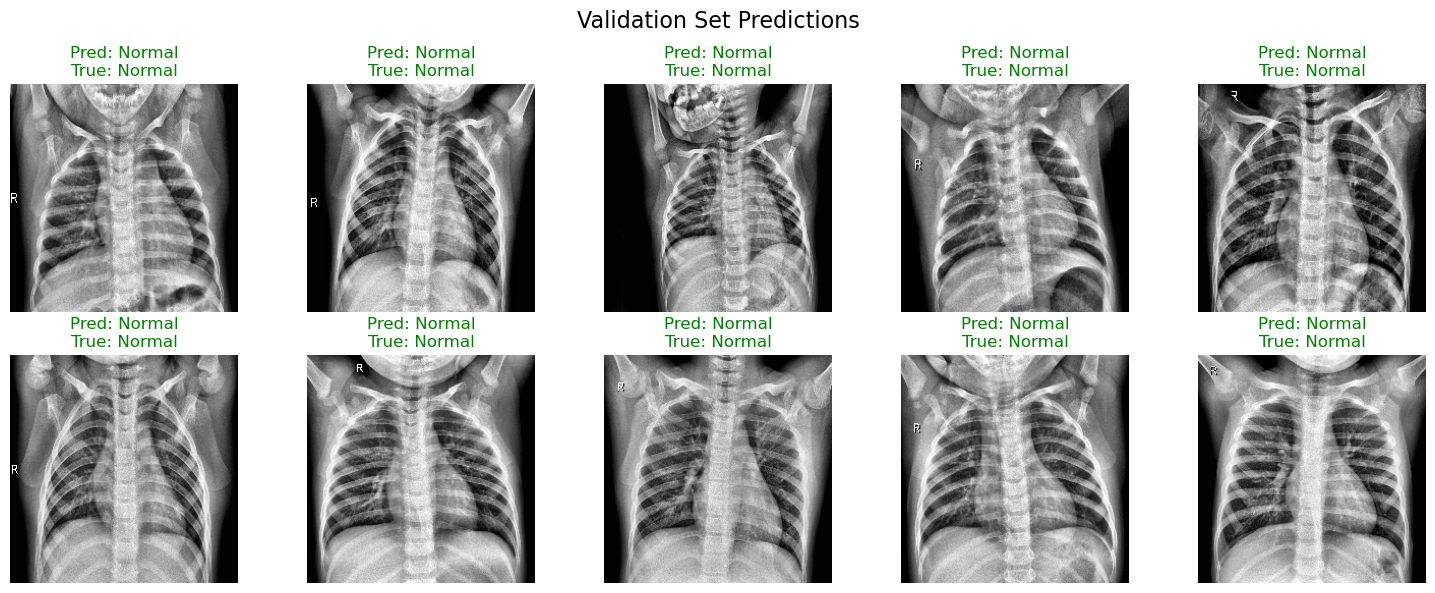

In [87]:
# --- 5.5 Display Example Predictions ---

# Function to display images with predictions
def display_val_images(model, val_data, class_labels, num_images=10):
    images, labels = next(iter(val_data))  # Get a batch of validation images
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class index
    true_labels = np.argmax(labels, axis=1)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Validation Set Predictions", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
            
        # Squeeze to (224, 224) for displaying grayscale
        ax.imshow(images[i].squeeze(), cmap='gray')
        
        pred_class = class_labels[pred_labels[i]]
        true_class = class_labels[true_labels[i]]
        
        ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}", 
                     color='green' if pred_class == true_class else 'red')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call function to display validation set images with predictions
display_val_images(model, val_generator, classes)

In [88]:
# --- 6.1 Save and Reload Model Example (Corrected) ---

from tensorflow.keras.models import load_model
from tensorflow.keras.saving import custom_object_scope

# 1. Save the model in the new .keras format
print("Saving model in .keras format...")
model.save("AttentiveLightNet.keras")
print("Model saved.")

# 2. Load the model directly.
# Because you used @register_keras_serializable,
# Keras knows how to find your custom components.
# No custom_object_scope is needed.
print("Loading model...")
loaded_model = load_model("AttentiveLightNet.keras")
print("Model loaded successfully.")

# Verify it loaded
loaded_model.summary()

Saving model in .keras format...
Model saved.
Loading model...
Model loaded successfully.


Model: "AttentiveLightNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 56, 56,    │          0 │ max_pooling2d_21… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 56, 56,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │        544 │ spatial_dropout2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_18 │ (None, 56, 56,    │        688 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_19 │ (None, 56, 56,    │        944 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │        544 │ max_pooling2d_22… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 56, 56,    │          0 │ conv2d_22[0][0],  │
│ (Concatenate)       │ 128)              │            │ separable_conv2d… │
│                     │                   │            │ separable_conv2d… │
│                     │                   │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_9[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 16)        │      2,064 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │      2,176 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 128)              │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 28, 28,    │          0 │ multiply_9[0][0]

 Total params: 1,032,156 (3.94 MB)

 Trainable params: 343,442 (1.31 MB)

 Non-trainable params: 1,824 (7.12 KB)

 Optimizer params: 686,890 (2.62 MB)